In [1]:
%pip install plotly nbformat>=4.2.0 ipywidgets>=8.0.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
import sys
sys.path.append(r'c:\Users\ice\projects\iris')

from PIL import Image as PILImage  # Rename to avoid conflict
from tqdm.notebook import tqdm
import plotly.graph_objects as go

from iris.config.data_pipeline_config_manager import DataPipelineConfigManager
from iris.config.embedding_pipeline_config_manager import EmbeddingPipelineConfigManager
from iris.data_pipeline.mongodb_manager import MongoDBManager
from iris.embedding_pipeline.embedding_handler import EmbeddingHandler
from iris.embedding_pipeline.embedding_database import EmbeddingDatabase

In [4]:
# Initialize configuration managers
data_config = DataPipelineConfigManager()
embedding_config = EmbeddingPipelineConfigManager()

shop_config = data_config.shop_configs["nikolaj_storm"]  # Select shop
mongodb_config = data_config.mongodb_config

# Create MongoDB manager
mongodb_manager = MongoDBManager(shop_config, mongodb_config)

# Initialize the EmbeddingHandler and Database
embedding_handler = EmbeddingHandler(embedding_config.clip_config)
embedding_db = EmbeddingDatabase(embedding_config.database_config)

In [5]:
# Convert cursor to list since it can only be iterated once
image_dataset = list(mongodb_manager.get_collection(
    mongodb_manager.mongodb_config.image_metadata_collection
).find())

# Add a progress bar with total count
for image_data in tqdm(image_dataset, desc="Processing images", total=len(image_dataset)):
    with PILImage.open(image_data['local_path']).convert("RGBA") as img:
        embedding = embedding_handler.get_embedding(img)
        embedding_db.add_embedding(embedding, id=image_data['image_hash'])

Processing images:   0%|          | 0/366 [00:00<?, ?it/s]

In [12]:
# Get the query hash's index and embedding
query_hash = '23373a5dc273beeb756d7bc83e15d532'

# Find index of the query hash in the database
hash_index = embedding_db.ids.index(query_hash)
query_embedding = embedding_db.embeddings[hash_index]

# Search for nearest neighbors
results = embedding_db.search(query_embedding, k=50)
print("Nearest neighbors for query hash", query_hash, ":", results)

Nearest neighbors for query hash 23373a5dc273beeb756d7bc83e15d532 : [('23373a5dc273beeb756d7bc83e15d532', np.float32(0.0)), ('34d96d3093c90a88c0d432672022a4c5', np.float32(0.22660434)), ('f6ecab9fad7be9a5e6773e3bb4026b71', np.float32(0.24525821)), ('d209b78d0cfc7b75f447c2d0ae5d3160', np.float32(0.2789879)), ('7185d5e4e2c88e505ce2c2abf98796a6', np.float32(0.2829302)), ('1583eff240936bf5479f663711aaed69', np.float32(0.32272804)), ('4d858edeaed3722cb5e4de73effa5e9a', np.float32(0.4296469)), ('5f8a3e26947356ba91e1fb4d9eca8e3f', np.float32(0.50068927)), ('6954dc6fce6945ba0e2da0e778b72765', np.float32(0.54273415)), ('cf01c8937b391ab760476f80f5cf3c4b', np.float32(0.5501095)), ('61ebb1e315d5f6d3f8989e8cb3a4ce67', np.float32(0.55094326)), ('46b26538e6e082f8af12c04ced6a7cbd', np.float32(0.551293)), ('828d488576f7aa76a42ce8c88ef947a3', np.float32(0.55190927)), ('2c435a7ce800e13f66fac37c80360ff9', np.float32(0.55534256)), ('06479de9831d5029521cd7353b9c9fd6', np.float32(0.5569595)), ('b3e15be1c5afe


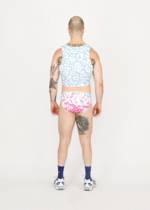
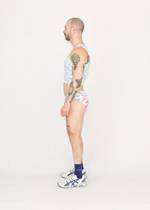
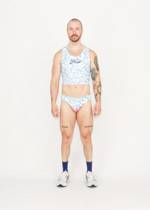
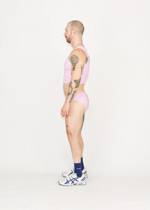
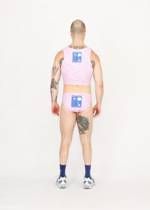
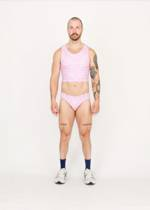
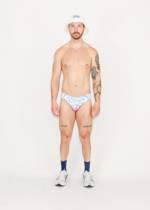
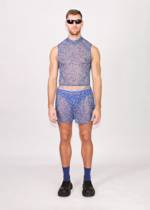
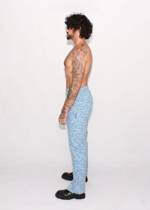
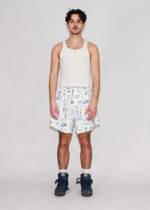
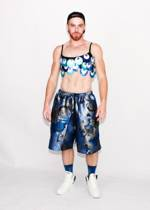
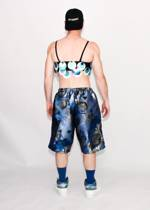
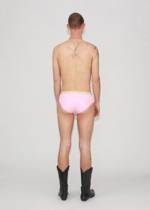
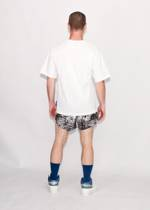
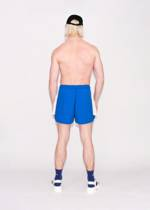
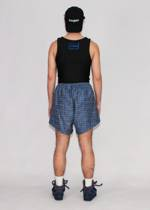
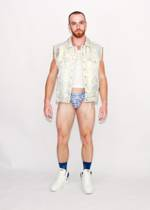
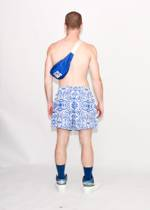
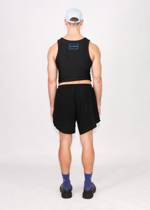
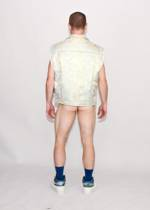
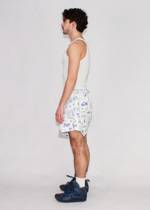
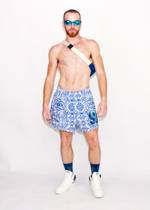
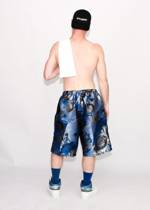
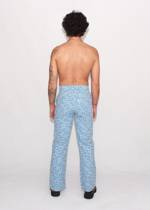
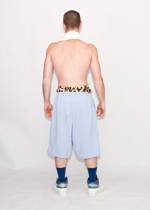
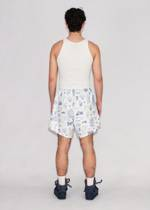
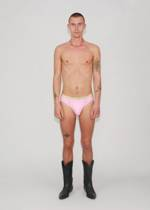
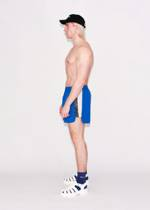
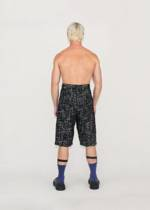
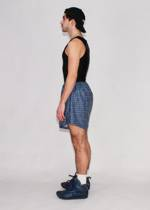
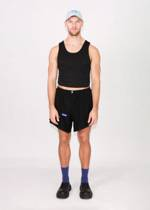
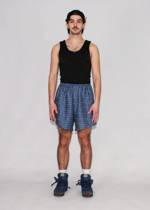
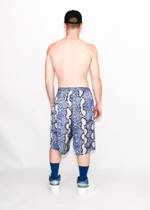
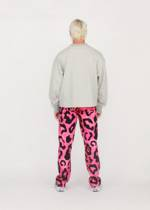
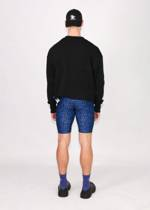
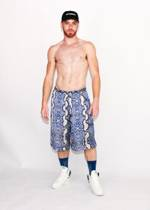
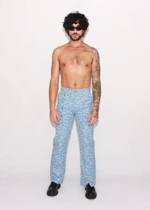
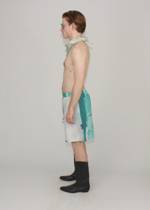
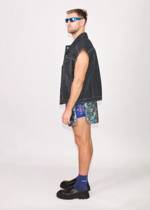
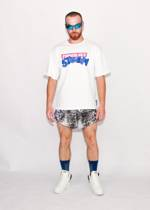
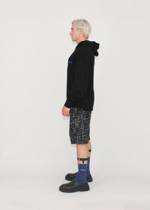
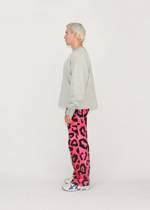
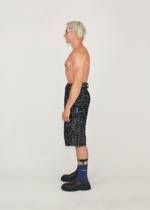
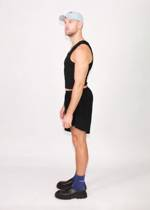
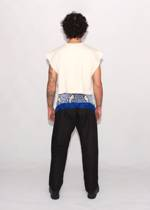
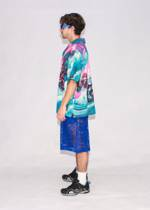
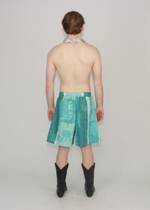
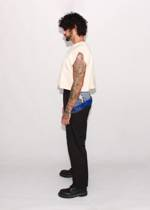
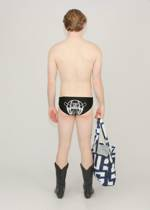
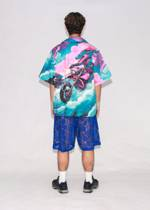

In [14]:
import plotly.graph_objects as go
from IPython.display import display, HTML
import base64
from io import BytesIO
from PIL import Image as PILImage

def get_image_html(path, size=(100, 140)):
    """Create HTML img tag with embedded base64 image"""
    with PILImage.open(path) as img:
        img.thumbnail(size)
        buffered = BytesIO()
        img.save(buffered, format='JPEG', quality=70)
        img_b64 = base64.b64encode(buffered.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_b64}" style="max-width:none">'

# Extract data for plot
indices = list(range(len(results)))
distances = [dist for _, dist in results]

# Get paths for all images
hash_to_path = {data['image_hash']: data['local_path'] for data in image_dataset}
paths = [hash_to_path[hash_val] for hash_val, _ in results]

# Create scatter plot with simpler hover text
fig = go.Figure(data=go.Scatter(
    x=indices,
    y=distances,
    mode='lines+markers',
    marker=dict(size=8),
    text=[f'Index: {i}<br>Hash: {hash_val}<br>Distance: {dist:.4f}' 
          for i, (hash_val, dist) in enumerate(results)],
    hovertemplate='%{text}<extra></extra>'
))

fig.update_layout(
    title='Image Similarity Plot',
    xaxis_title='Index',
    yaxis_title='Distance',
    width=800,
    height=400,
    showlegend=False
)

# Display plot
fig.show()

# Create grid of thumbnails below the plot
html = ['<div style="display: flex; flex-wrap: wrap; gap: 10px;">']

for i, ((hash_val, dist), path) in enumerate(zip(results, paths)):
    img_html = get_image_html(path, size=(150, 210))
    item_html = f"""
    <div style='text-align: center; border: 1px solid #ddd; padding: 5px;'>
        {img_html}
        <br>
        <small>Index: {i}</small><br>
        <small>Distance: {dist:.4f}</small><br>
        <small>Hash: {hash_val}</small>
    </div>
    """
    html.append(item_html)

html.append('</div>')
display(HTML(''.join(html)))